In [1]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import pickle
import pandas as pd
import pickle
import numpy as np
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.analysis.local_env import JmolNN
import matplotlib.pyplot as plt
import scipy.ndimage


In [135]:
# Instantiate functions
def get_el_str(elements):
    return elements[0]+"-"+elements[1]

def get_dist(row):
    return np.sqrt((row.x_min_energy - -1.3705410821643291)**2 + (row.y_min_energy - -0.39153306613226446)**2)

def contains_el(bulk_elements, element = 'Tc'):
    if bulk_elements[0] == element  or bulk_elements[1] == element:
        return True
    else:
        return False
    
def get_el(el_list):
    return el_list[0]

def get_eah(mpid):
    return eah[mpid]["e_above_hull"]

def make_contour_plot(ax, grid):
    # make meshgrid
    grid_x = np.linspace(-2.45, 0.25, np.shape(grid)[0])
    grid_y = np.linspace(-0.75, 1.5, np.shape(grid)[1])
    x_g = np.expand_dims(grid_x, axis=1)
    y_g = np.expand_dims(grid_y, axis=0)
    XX,YY = np.meshgrid(x_g,y_g)
    
    # smooth the grid
    grid  = scipy.ndimage.gaussian_filter(grid,4)
    
    # plot
    contour_plot = ax.contourf(XX, YY, grid, cmap = "Greys", vmin = 0.01)
    
    
def make_figure4(binary_df, unary_df, grid, el_colors, fname, lims):
    ys = binary_df.y_min_energy.tolist()
    xs = binary_df.x_min_energy.tolist()
    element_combos = binary_df.bulk_elements.tolist()
    bulks = binary_df.bulk_atoms.tolist()

    fig,ax = plt.subplots(1,1)
    fig.set_size_inches(*lims["size"])
    x_g = np.expand_dims(grid_x, axis=1)
    y_g = np.expand_dims(grid_y, axis=0)
    
    # add contour plot
    make_contour_plot(ax, grid)
    
    # add scatter pies
    for idx in range(len(xs)):
        plot_a_pie(ax, xs[idx], ys[idx], bulks[idx], element_combos[idx])
        
    # plot unary
    plot_pure_points(ax, unary_df)

    # adjust axes
    ax.plot([-3.75,0.25],[-1.17,-1.17], 'k--')
    ax.plot([-3.75,0.25],[0.5,0.5], 'k--')
    ax.set_xlim(lims["xlim"])
    ax.set_ylim(lims["ylim"])
    ax.set_xlabel("*CO adsorption energy [eV]")
    ax.set_ylabel("*OH adsorption energy [eV]")
    plt.savefig(fname)
    
    
def plot_a_pie(ax, x, y, bulk, els):
    comp = AseAtomsAdaptor.get_structure(bulk).composition.fractional_composition.as_dict()
    x1 = np.cos(2 * np.pi * np.linspace(0, comp[els[0]]))
    y1 = np.sin(2 * np.pi * np.linspace(0, comp[els[0]]))
    marker1 = np.row_stack([[0, 0], np.column_stack([x1, y1])])
    s1 = np.abs(marker1).max()
    x2 = np.cos(2 * np.pi * np.linspace(comp[els[0]], 1))
    y2 = np.sin(2 * np.pi * np.linspace(comp[els[0]], 1))
    marker2 = np.row_stack([[0, 0], np.column_stack([x2, y2])])
    s2 = np.abs(marker2).max()
    ax.scatter(x, y, marker = marker1, s = 100*s1, facecolor=el_colors[els[0]])
    ax.scatter(x, y, marker = marker2, s = 100*s2, facecolor=el_colors[els[1]])
    
def plot_pure_points(ax, unary_df):
    xs = unary_df.x_min_energy.tolist()
    ys = unary_df.y_min_energy.tolist()
    els = unary_df.el.tolist()
    
    for idx in range(len(xs)):
        ax.scatter(xs[idx],ys[idx], facecolors=el_colors[els[idx]], s=400, marker = "s", edgecolors = 'k')
        ax.annotate(els[idx], (xs[idx]+0.03,ys[idx]+0.03), fontsize=14)
    

In [140]:
# Load extra data
with open("../e_above_hull/e_above_hull_info.pkl", "rb") as f:
    eah = pickle.load(f)
with open("../processing/data/20220413_grid.pkl", "rb") as f:
    grid = pickle.load(f)
print(np.max(grid))

0.22451875190773465


In [129]:
# Load binary data and make mods
df = pd.read_pickle('../processing/outputs/post_processed_catlas_data_20220701_vals_2.pkl')

df = df[df["111-like"] & (~df.y_min_energy.isnull())]

df["elstr"] = df.bulk_elements.apply(get_el_str)
df["dist"] = df.apply(get_dist, axis =1)

df["Tc_true"] = df.bulk_elements.apply(contains_el)
df = df[~df["Tc_true"]]

df["e_above_hull"] = df.bulk_mpid.apply(get_eah)
df = df[df.e_above_hull <= 0.1]

grouped = df.sort_values("dist").groupby("elstr", as_index=False).first()

In [94]:
# Load unary data and make mods
unary= pd.read_pickle("../processing/outputs/post_processed_catlas_data_unary_20220630.pkl")

unary = unary[unary["111-like"]]

unary['el'] = unary.bulk_elements.apply(get_el)
unary = unary[unary.el != "Tc"]

lowest_eah_mpids = ['mp-8', 'mp-49', 'mp-91', 'mp-146', 'mp-101', 'mp-74', 'mp-54',
                    'mp-13', 'mp-30', 'mp-81', 'mp-2', 'mp-126', 'mp-23', 'mp-79', 'mp-33', 'mp-129',
                    'mp-90', 'mp-989737', 'mp-989737', 'mp-989737', 'mp-75', 'mp-1056037', 'mp-1056486',
                    'mp-1061133', 'mp-1056438', 'mp-113', 'mp-103', 'mp-131', 'mp-1096861', 'mp-1187739',
                    'mp-1187739', 'mp-6985', 'mp-36', 'mp-8634', 'mp-6986']

unary = unary[unary.bulk_mpid.isin(lowest_eah_mpids)]
plot_unary = unary.groupby(by = "el").agg({"x_min_energy": np.mean, "y_min_energy": np.mean}).reset_index()

In [117]:
el_colors = {"Pt":"#4A235A", "Ti":"#B7950B", "Ni":"#A569BD", "Re":"#EBDEF0",
             "Ru":"#BB8FCE", "Nb":"#F4D03F", "Co":'#D2B4DE', "Zn":"#707B7C",
             "Mo":"#FCF3CF", "Pd":'#5B2C6F', "V":"#F1C40F", "Rh":"#7D3C98", 
             "Fe":"#493C05", "Zr":"#BBA54A", "Mn":"#F9E79F", "Ag":'#424949', "Au":'#515A5A',
             "Cu":'#EAEDED', 'Ir':'#6C3483', 'Cr': "#F7DC6F", "Os":'#8E44AD',
             "Hf":"#9A7D0A", "W":"#FEF9E7", "Ta":'#D4AC0D', "Sc":"#645209", "Y":"#7D6608",
             "Cd":"#BFC9CA", "Hg":"k"}

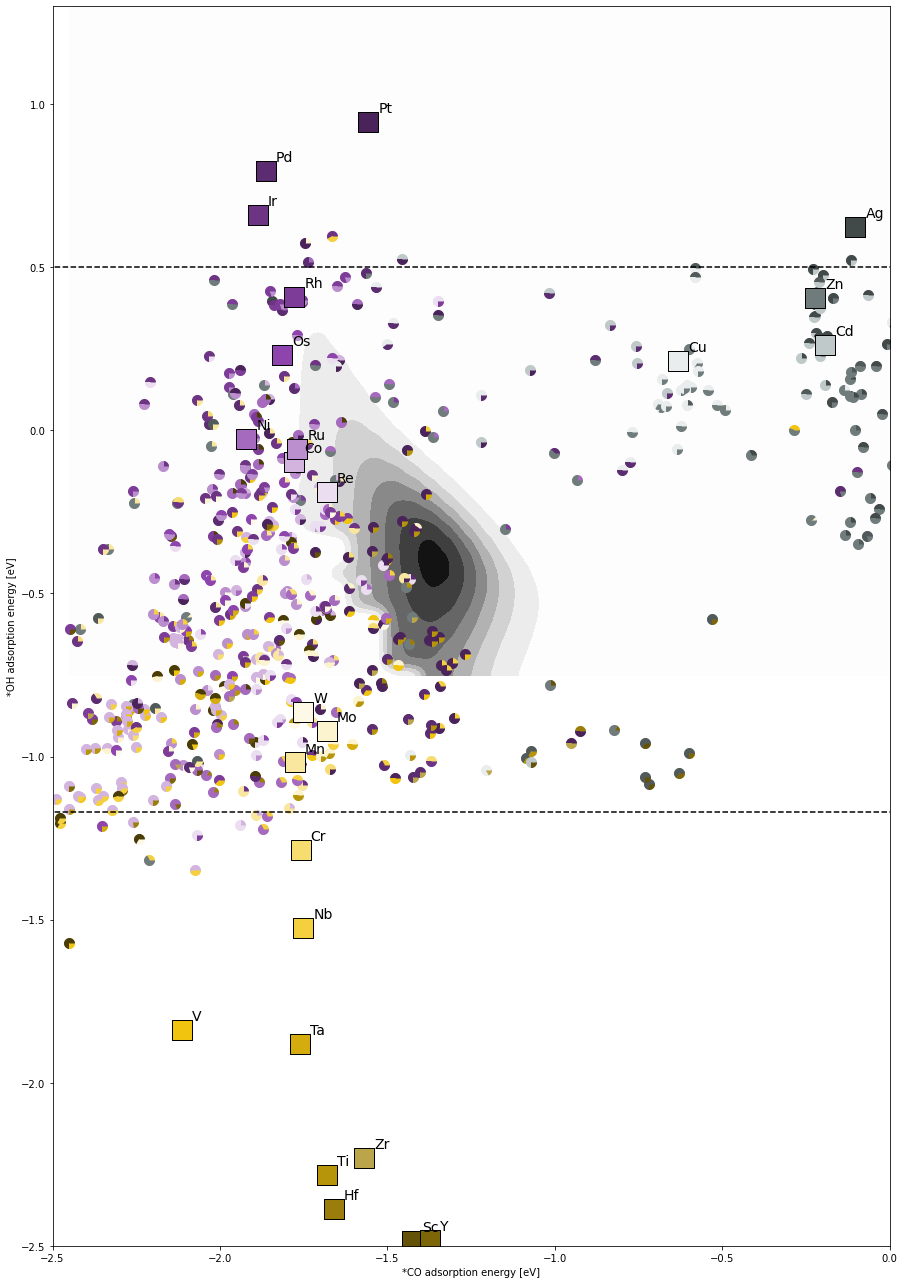

In [138]:
make_figure4(df, plot_unary, grid, el_colors, fname = "main-one.svg", lims = {"size": [15, 22.8], "xlim":[-2.5,0], "ylim": [-2.5,1.3]})

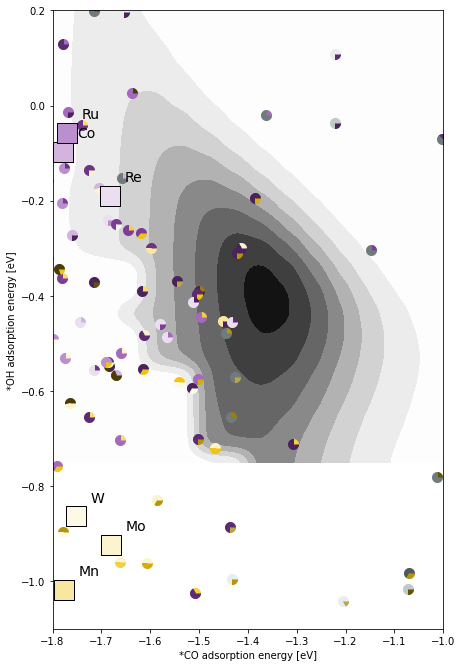

In [139]:
make_figure4(grouped, plot_unary, grid, el_colors, fname = "inset.svg", lims = {"size": [7, 11.375], "xlim":[-1.8,-1], "ylim": [-1.1,0.2]})

In [ ]:
ys = grouped.y_min_energy.tolist()
xs = grouped.x_min_energy.tolist()
els = grouped.bulk_elements.tolist()
bulks = grouped.bulk_atoms.tolist()

x = plotable_pure.min_dE_gemnet_t_direct_h512.tolist()
y = plotable_pure.y_min_energy.tolist()

fig,ax = plt.subplots(1,1)
# ax.set_facecolor('xkcd:salmon')
fig.set_size_inches()
x_g = np.expand_dims(grid_x, axis=1)
y_g = np.expand_dims(grid_y, axis=0)

XX,YY = np.meshgrid(x_g,y_g)


ax.contourf(XX, YY, grid, cmap = "Greys", vmin = 0.01)

for line in boundary_pts:
    ax.plot(line[0],line[1], "k-") 
ax.plot([-3.75,0.25],[-1.17,-1.17], 'k--')
ax.plot([-3.75,0.25],[0.5,0.5], 'k--')
ax.set_xlim()
ax.set_ylim()
ax.set_xlabel("*CO adsorption energy")
ax.set_ylabel("*OH adsorption energy")


for idx in range(len(xs)):
#     if el_colors[els[idx][0]] != 'k' and el_colors[els[idx][1]] !="k":
    comp = AseAtomsAdaptor.get_structure(bulks[idx]).composition.fractional_composition.as_dict()
    x1 = np.cos(2 * np.pi * np.linspace(0, comp[els[idx][0]]))
    y1 = np.sin(2 * np.pi * np.linspace(0, comp[els[idx][0]]))
    marker1 = np.row_stack([[0, 0], np.column_stack([x1, y1])])
    s1 = np.abs(marker1).max()
    x2 = np.cos(2 * np.pi * np.linspace(comp[els[idx][0]], 1))
    y2 = np.sin(2 * np.pi * np.linspace(comp[els[idx][0]], 1))
    marker2 = np.row_stack([[0, 0], np.column_stack([x2, y2])])
    s2 = np.abs(marker2).max()
    ax.scatter(xs[idx], ys[idx], marker = marker1, s = 200*s1, facecolor=el_colors[els[idx][0]])
    ax.scatter(xs[idx], ys[idx], marker = marker2, s = 200*s2, facecolor=el_colors[els[idx][1]])
#     elif el_colors[els[idx][0]] != 'k':
#         ax.scatter(xs[idx], ys[idx], marker ='o', s = 25, facecolor=el_colors[els[idx][0]])
#     elif el_colors[els[idx][1]] != 'k':
#         ax.scatter(xs[idx], ys[idx], marker ='o', s = 25, facecolor=el_colors[els[idx][1]])
#     else:
#         ax.scatter(xs[idx], ys[idx], marker ='o', s = 1, facecolor='k')
#     if el_colors[els[idx][1]] !="k" and el_colors[els[idx][0]] !="k":
#         ax.scatter(xs[idx], ys[idx], marker = marker2, s = 100*s2, facecolor=el_colors[els[idx][1]])


# for idx,el in enumerate(plotable_pure.el.tolist()):
#     ax.scatter(x[idx],y[idx], facecolors=el_colors[el], s=400, marker = "s", edgecolors = 'k')
#     ax.annotate(el,(x[idx]+0.03,y[idx]+0.03), fontsize=14)



plt.savefig("zoomed.svg")

In [132]:
grouped

,elstr,bulk_atoms,bulk_mpid,bulk_data_source,bulk_natoms,bulk_xc,bulk_nelements,bulk_elements,slab_surface_object,slab_millers,...,y_all_energies_direct,y_min_energy_direct,x_all_energies,x_min_energy,hit,y_min_energy,y_all_energies,dist,Tc_true,e_above_hull
0,Ag-Cd,"(Atom('Cd', [-1.60813088, -0.936035539318807, ...",mp-1226933,ocdata_bulks,4,RPBE,2,"[Ag, Cd]",<ocdata.surfaces.Surface object at 0x7f047138d...,"(0, 0, 1)",...,"[0.9258217811584473, 0.2855304479598999, 0.214...",0.214207,"[-0.26467347145080566, -0.1799028515815735, -0...",-0.264673,1.411433e-08,0.221597,"[0.22675544023513794, 0.22930604219436646, 0.2...",1.264465,False,0.027645
1,Ag-Pd,"(Atom('Ag', [1.4408392335318563, 0.83204996370...",mp-1183222,ocdata_bulks,2,RPBE,2,"[Ag, Pd]",<ocdata.surfaces.Surface object at 0x7f048426a...,"(1, 0, 0)",...,"[0.6313202381134033, 1.2696938514709473, 0.572...",0.494771,"[-1.845564842224121, -0.1332254409790039, -1.4...",-1.845565,4.397383e-02,0.397440,"[0.4006829857826233, 0.9061450362205505, 0.436...",0.920938,False,0.013803
2,Ag-Zn,"(Atom('Zn', [0.0, 0.0, 0.0], tag=0, momentum=[...",mp-1093999,ocdata_bulks,12,RPBE,2,"[Ag, Zn]",<ocdata.surfaces.Surface object at 0x7f046ec56...,"(0, 0, 1)",...,"[0.2129960060119629, 0.8667199611663818, 1.197...",-0.039548,"[-0.14514189958572388, -0.41516026854515076, 0...",-0.415160,8.593754e-06,-0.076342,"[-0.07241994142532349, 0.8641701340675354, -0....",1.006031,False,0.014102
3,Au-Cd,"(Atom('Cd', [-1.57956653, 0.910708266209771, -...",mp-1226718,ocdata_bulks,2,RPBE,2,"[Au, Cd]",<ocdata.surfaces.Surface object at 0x7f056bca9...,"(0, 0, 1)",...,"[0.8754403591156006, 0.32498860359191895, 0.34...",0.322859,"[-0.2504681348800659, -0.23131996393203735, -0...",-0.250468,5.697535e-08,0.112544,"[0.1125440001487732, 0.12616300582885742, 0.12...",1.228274,False,0.056352
4,Au-Cu,"(Atom('Cu', [0.0, 1.912506985, 1.912506985], t...",mp-2258,ocdata_bulks,4,RPBE,2,"[Au, Cu]",<ocdata.surfaces.Surface object at 0x7f057c6cb...,"(1, 1, 1)",...,"[0.30324292182922363, 1.4357972145080566, 0.21...",0.166017,"[-0.603775143623352, -0.2627786099910736, -0.4...",-0.603775,9.627321e-06,0.076559,"[0.2621975541114807, 1.299957036972046, 0.2485...",0.898354,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,Ti-Zn,"(Atom('Ti', [3.333330056420891e-09, 3.28711143...",mp-1187531,ocdata_bulks,8,RPBE,2,"[Ti, Zn]",<ocdata.surfaces.Surface object at 0x7f04758d0...,"(1, 0, 0)",...,"[-0.5984947085380554, -0.3035402297973633, 0.2...",-0.898073,"[-1.4454108476638794, 0.09223318099975586, -0....",-1.445411,2.245188e-01,-0.479079,"[-0.4730611741542816, -0.4583932161331177, -0....",0.115194,False,0.006071
140,V-W,"(Atom('V', [0.0, 0.0, 0.0], tag=0, momentum=[0...",mp-1216231,ocdata_bulks,2,RPBE,2,"[V, W]",<ocdata.surfaces.Surface object at 0x7f0461dee...,"(0, 0, 1)",...,"[-0.2232837677001953, -0.6265745759010315, -0....",-0.818703,"[-1.4551228284835815, -1.4134771823883057, -1....",-1.541568,2.245188e-01,-0.581619,"[-0.3050987422466278, -0.4186026453971863, -0....",0.255701,False,0.000000
141,V-Zn,"(Atom('V', [2.092134896311717, 4.1490591898145...",mp-30883,ocdata_bulks,9,RPBE,2,"[V, Zn]",<ocdata.surfaces.Surface object at 0x7f04532ff...,"(1, 1, 0)",...,"[0.6175093650817871, 0.2376105785369873, 0.109...",0.104641,"[-0.016070246696472168, -0.28578048944473267, ...",-0.285780,4.620750e-07,0.000552,"[0.07756006717681885, 0.047672152519226074, 0....",1.153445,False,0.000000
142,Y-Zn,"(Atom('Zn', [-1.34387722, 2.327663625, 2.13781...",mp-30885,ocdata_bulks,6,RPBE,2,"[Y, Zn]",<ocdata.surfaces.Surface object at 0x7f0452b81...,"(0, 0, 1)",...,"[-0.9947188496589661, 0.5241854190826416, -0.9...",-1.057129,"[-0.8224369287490845, -0.0635719895362854, -0....",-0.822437,2.654528e-02,-0.918344,"[-0.9183441400527954, -0.8569636940956116, -0....",0.760229,False,0.009830
